## Analisis del problema
Se desea verificar si una persona esta usando una mascarilla en una foto y para esto se usara el modelo CNN, en donde se dividiran entre personas con y sin mascarilla.



##Autores
* Gustavo Méndez
* Allen Jiménez

### Importar librerias

In [ ]:
!pip install tensorflow-gpu==2.8.0

     |████████████████████████████████| 497.5 MB 24 kB/s 
     |████████████████████████████████| 462 kB 62.6 MB/s 


In [ ]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Activation, MaxPooling2D, Flatten

import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D,SeparableConv2D
from tensorflow import keras
from tensorflow.keras import layers
import time
from keras.models import load_model
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score,ConfusionMatrixDisplay,classification_report

import itertools
import os
import dlib
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime
import plotly.express as px
from random import random
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from google.colab.patches import cv2_imshow
from numpy import argmax

%load_ext tensorboard

In [ ]:
import shutil

In [ ]:
tf.config.experimental.set_visible_devices([], 'GPU')

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
!wget https://gitlab.com/ejimenez/mascarilla/-/raw/main/mascarilla.zip

--2022-04-26 04:52:10--  https://gitlab.com/ejimenez/mascarilla/-/raw/main/mascarilla.zip
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171065389 (163M) [application/zip]
Saving to: ‘mascarilla.zip’

mascarilla.zip      100%[===================>] 163.14M   119MB/s    in 1.4s    

2022-04-26 04:52:12 (119 MB/s) - ‘mascarilla.zip’ saved [171065389/171065389]



In [ ]:
!unzip /content/mascarilla.zip

Streaming output truncated to the last 5000 lines.
  inflating: Mascarilla/without_mask/without_mask_3298.jpg  
  inflating: Mascarilla/without_mask/without_mask_3299.jpg  
  inflating: Mascarilla/without_mask/without_mask_33.jpg  
  inflating: Mascarilla/without_mask/without_mask_330.jpg  
  inflating: Mascarilla/without_mask/without_mask_3300.jpg  
  inflating: Mascarilla/without_mask/without_mask_3301.jpg  
  inflating: Mascarilla/without_mask/without_mask_3302.jpg  
  inflating: Mascarilla/without_mask/without_mask_3303.jpg  
  inflating: Mascarilla/without_mask/without_mask_3304.jpg  
  inflating: Mascarilla/without_mask/without_mask_3305.jpg  
  inflating: Mascarilla/without_mask/without_mask_3306.jpg  
  inflating: Mascarilla/without_mask/without_mask_3307.jpg  
  inflating: Mascarilla/without_mask/without_mask_3308.jpg  
  inflating: Mascarilla/without_mask/without_mask_3309.jpg  
  inflating: Mascarilla/without_mask/without_mask_331.jpg  
  inflating: Mascarilla/without_mask/w

In [ ]:
with_maskImage = os.listdir('/content/Mascarilla/with_mask')
without_maskImage = os.listdir('/content/Mascarilla/without_mask')

In [ ]:
os.mkdir('./train')
os.mkdir('./train/with_mask')
os.mkdir('./val')
os.mkdir('./val/with_mask')
os.mkdir('./test')
os.mkdir('./test/with_mask')


os.mkdir('./train/without_mask')
os.mkdir('./val/without_mask')
os.mkdir('./test/without_mask')

In [ ]:
with_mask_train_len = int(np.round(0.6 * len(with_maskImage), 0))
with_mask_val_len = int(np.round(0.7 * len(with_maskImage), 0))


for i in range(with_mask_train_len):
    shutil.copy(os.path.join('/content/Mascarilla/with_mask', with_maskImage[i]), './train/with_mask')

for i in range(with_mask_train_len, with_mask_val_len):
    shutil.copy(os.path.join('/content/Mascarilla/with_mask', with_maskImage[i]), './val/with_mask')

for i in range(with_mask_val_len, len(with_maskImage)):
    shutil.copy(os.path.join('/content/Mascarilla/with_mask', with_maskImage[i]), './test/with_mask')


without_mask_train_len = int(np.round(0.6 * len(without_maskImage), 0))
without_mask_val_len = int(np.round(0.7 * len(without_maskImage), 0))



for i in range(without_mask_train_len):
    shutil.copy(os.path.join('/content/Mascarilla/without_mask', without_maskImage[i]), './train/without_mask')

for i in range(without_mask_train_len, without_mask_val_len):
    shutil.copy(os.path.join('/content/Mascarilla/without_mask', without_maskImage[i]), './val/without_mask')

for i in range(without_mask_val_len, len(without_maskImage)):
    shutil.copy(os.path.join('/content/Mascarilla/without_mask', without_maskImage[i]), './test/without_mask')

In [ ]:
PATH_TRAIN_MASK = './train/with_mask'
PATH_VAL_MASK = './val/with_mask'
PATH_TEST_MASK = './test/with_mask'

PATH_TRAIN_NO_MASK = './train/without_mask'
PATH_VAL_NO_MASK = './val/without_mask'
PATH_TEST_NO_MASK = './test/without_mask'

PATH_TRAIN = './train'
PATH_VAL = './val'
PATH_TEST = './test'

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img

train_data_gen = ImageDataGenerator(rotation_range=30,
                                    width_shift_range=0.02,
                                    height_shift_range=0.02,
                                    zoom_range=[0.8,1.2],
                                    horizontal_flip=True,
                                    rescale=1/255
                                   )


val_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
train_mask_files = os.listdir(PATH_TRAIN_MASK)
train_no_mask_files = os.listdir(PATH_TRAIN_NO_MASK)

In [ ]:
training_data = train_data_gen.flow_from_directory(PATH_TRAIN, target_size=(200, 200), color_mode='rgb', class_mode='binary', batch_size=32)
val_data = val_data_gen.flow_from_directory(PATH_VAL, target_size=(200, 200), color_mode='rgb', class_mode='binary', batch_size=32)
test_data = test_data_gen.flow_from_directory(PATH_TEST, target_size=(200, 200), color_mode='rgb', class_mode='binary', batch_size=32)

Found 4532 images belonging to 2 classes.
Found 756 images belonging to 2 classes.
Found 2265 images belonging to 2 classes.


## Carga de datos

#### Entrenamiento

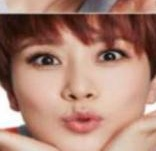

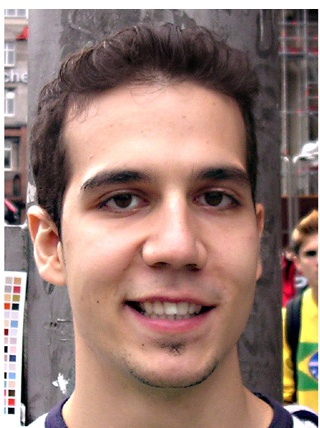

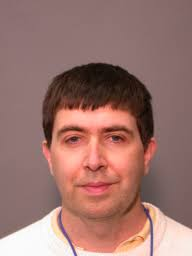

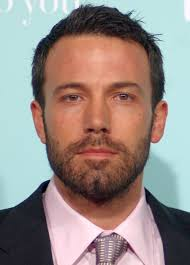

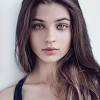

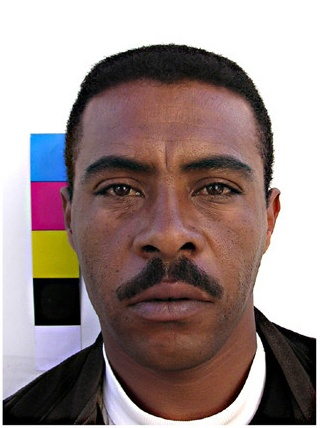

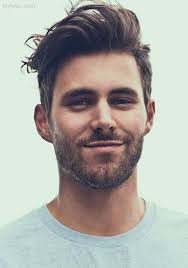

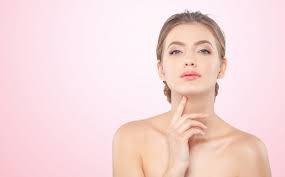

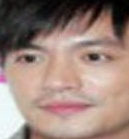

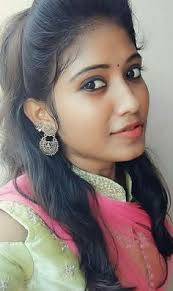

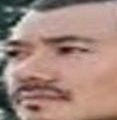

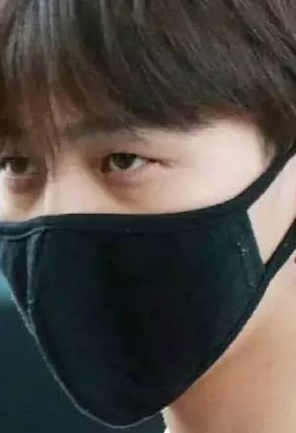

In [ ]:
filelist=[]
count=0
for path, subdirs, files in os.walk(PATH_TRAIN):
   #print(path, subdirs, files)
   for file in files:
     img=os.path.join(path, file)
     img = cv2.imread(img)
     cv2_imshow(img)
     if count==10:
       break
     count=count+1

#### Pruebas

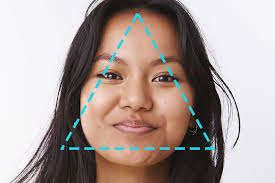

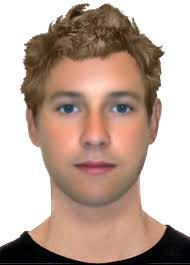

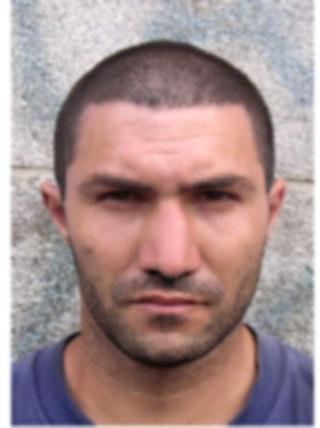

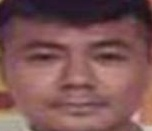

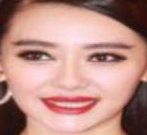

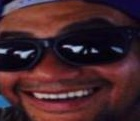

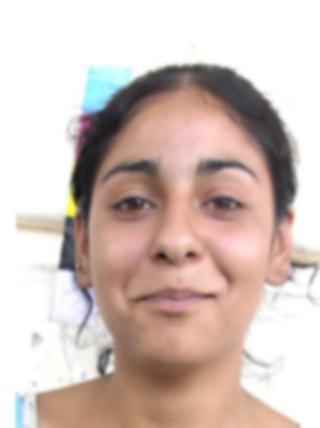

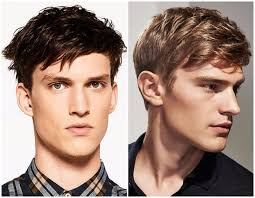

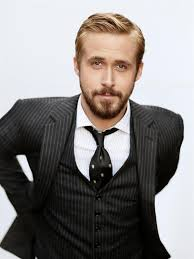

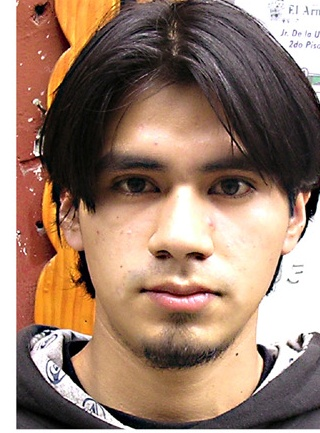

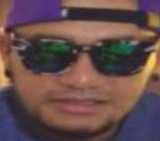

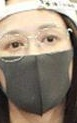

In [ ]:
filelist=[]
count=0
for path, subdirs, files in os.walk(PATH_TEST):
   #print(path, subdirs, files)
   for file in files:
     img=os.path.join(path, file)
     img = cv2.imread(img)
     cv2_imshow(img)
     if count==10:
       break
     count=count+1

#### Categorias

In [ ]:
categories=[]
lenCategories=0
for folder in os.listdir(PATH_TRAIN)[:3]:
  print(folder)
  categories.append(folder)
lenCategories= len(categories)

without_mask
with_mask


In [ ]:
img_size=100

training_data=[]

def create_training_data():
    for category in categories:
        path=os.path.join(PATH_TRAIN, category)
        class_num=categories.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(img_size,img_size))
                training_data.append([new_array,class_num])
            except Exception as e:
                print(e)
                pass
create_training_data()

## Visualizacion

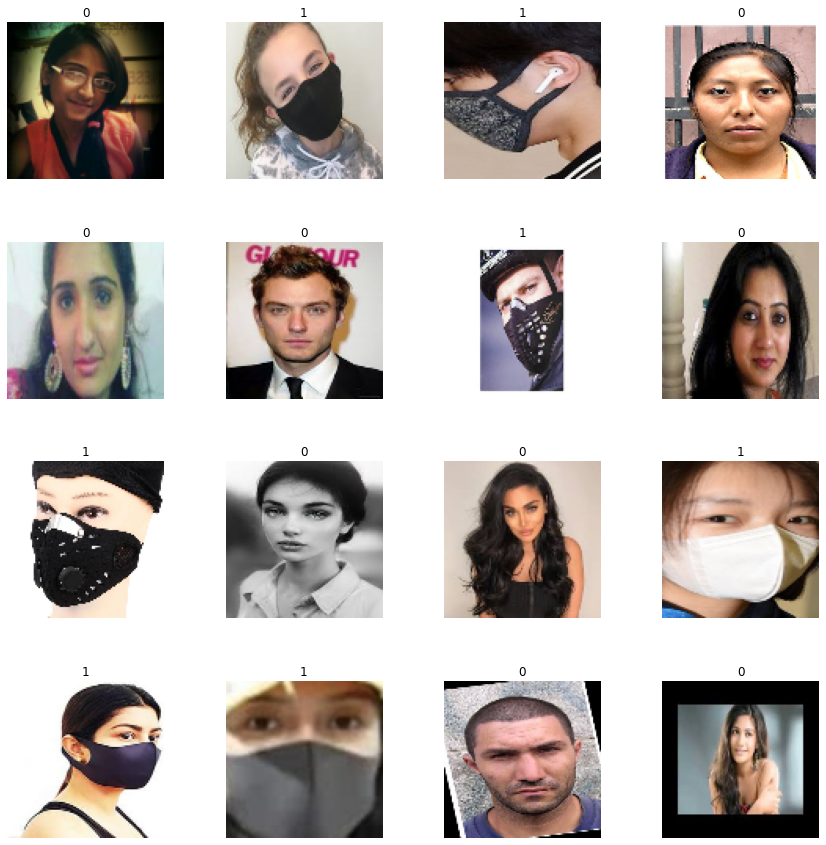

In [ ]:
W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes = axes.ravel()

n_training = len(training_data)

for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(training_data[index][0][:,:,::-1])
    axes[i].set_title(training_data[index][1])
    axes[i].axis('off')

plt.subplots_adjust(hspace = 0.4)

### Preparacion de los datos

In [ ]:
X=[]
y=[]

for categories_x, label in training_data:
    X.append(categories_x)
    y.append(label)
X= np.array(X).reshape(len(training_data),-1)

In [ ]:
X =  X.reshape(len(X),100,100,3)

In [ ]:
X.shape

(4532, 100, 100, 3)

In [ ]:
#X.shape
X = X/255.0
y=np.array(y)
#y.shape

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([2297, 2235]))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   test_size=0.20,
                                                   random_state=0)

In [ ]:
y_train = keras.utils.to_categorical(y_train, lenCategories)
y_test = keras.utils.to_categorical(y_test, lenCategories)

# Entrenamiento del modelo del deep leaning

In [ ]:
#https://www.dataquest.io/blog/learning-curves-machine-learning/
# Helper Functions  Learning Curves and Confusion Matrix
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    #plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.show()

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('accuracy_curve.png')
    #plt.show()
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('loss_curve.png')
    #plt.show()

https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/



The **batch size** is a number of samples processed before the model is updated.

The number of **epochs** is the number of complete passes through the training dataset.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                    

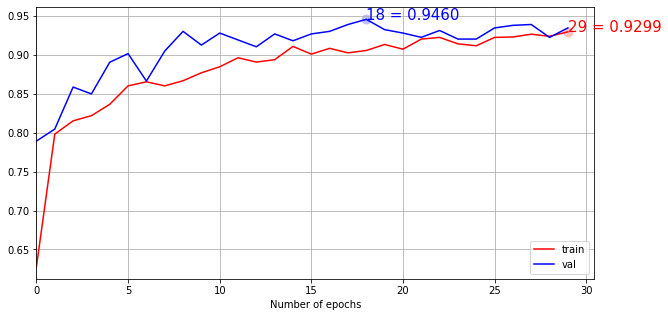

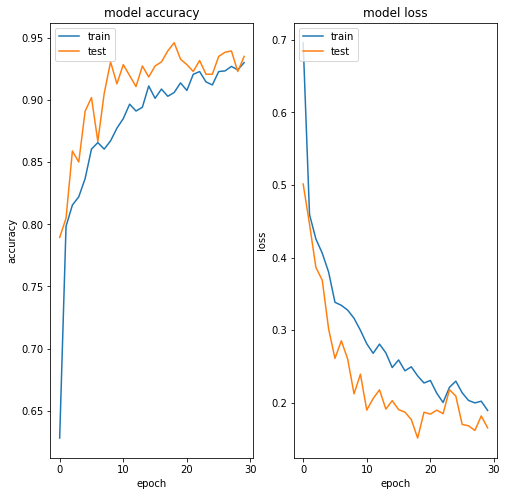

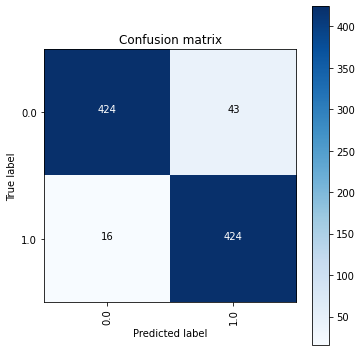

In [ ]:
def runKerasCNNAugment(a,b,c,d,e):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    chanDim = -1
    batch_size = 64
    num_classes = e
    epochs = 30
    img_rows,img_cols=100,100
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()

    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu',
                                     input_shape = (100,100,3)))
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
    #model.add(tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(tf.keras.layers.MaxPooling2D(2,2))
    model.add(tf.keras.layers.Dropout(0.2))

    #model.add(tf.keras.layers.Conv2D(128, (3,3), activation = 'relu'))
    #model.add(tf.keras.layers.MaxPooling2D(2,2))
    #model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(1024, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(1024, activation = 'relu'))

    model.add(tf.keras.layers.Dense(num_classes, activation = 'softmax'))
    model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(optimizer = opt, loss = 'BinaryCrossentropy', metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

    t= time.time()
    export= './frutas_{}.h5'.format(int(t))
    checkpoint_filepath = export

    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

    history = model.fit(datagen.flow(a,b, batch_size=batch_size),
                                  steps_per_epoch=len(a) / batch_size,
                                  epochs=epochs,
                        validation_data = (c, d),callbacks = [MetricsCheckpoint('logs'),model_checkpoint_callback] )
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1),
                                                    target_names=list(categories)), sep='')
    y_pred=np.argmax(y_pred,axis=1)
    Y_true =np.argmax(d,axis=1)
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()

    confusion_mtx = confusion_matrix(Y_true, y_pred)
    plot_confusion_matrix(confusion_mtx, classes = list(np.unique(b)))
    plt.show()
    return model

#modelo=runKerasCNNAugment(X_train, y_train, X_test, y_test,len(categories),class_weight2)
modelo=runKerasCNNAugment(X_train, y_train , X_test, y_test,len(categories))


In [ ]:
print("on valid data")
pred1=modelo.evaluate(X_test, y_test)
print("accuaracy", str(pred1[1]*100))
print("Total loss",str(pred1[0]*100))

on valid data
29/29 [==============================] - 8s 287ms/step - loss: 0.1653 - accuracy: 0.9350
accuaracy 93.49504113197327
Total loss 16.534996032714844


#Evaluacion

In [ ]:
predicted_classes = modelo.predict(X_test)
predicted_classes=np.argmax(predicted_classes,axis=1)

In [ ]:
evaluation = modelo.evaluate(X_test, y_test)
print('Test Accuracy: {}'.format(evaluation[1]))

29/29 [==============================] - 8s 288ms/step - loss: 0.1653 - accuracy: 0.9350
Test Accuracy: 0.9349504113197327


In [ ]:
np.argmax(y_test, axis=1, out=None)

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,

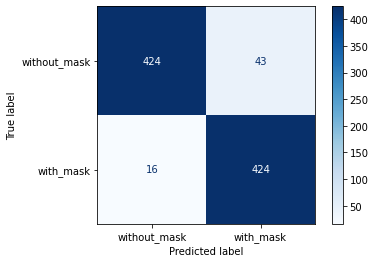

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1, out=None), predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

disp.plot(cmap=plt.cm.Blues)
plt.show()

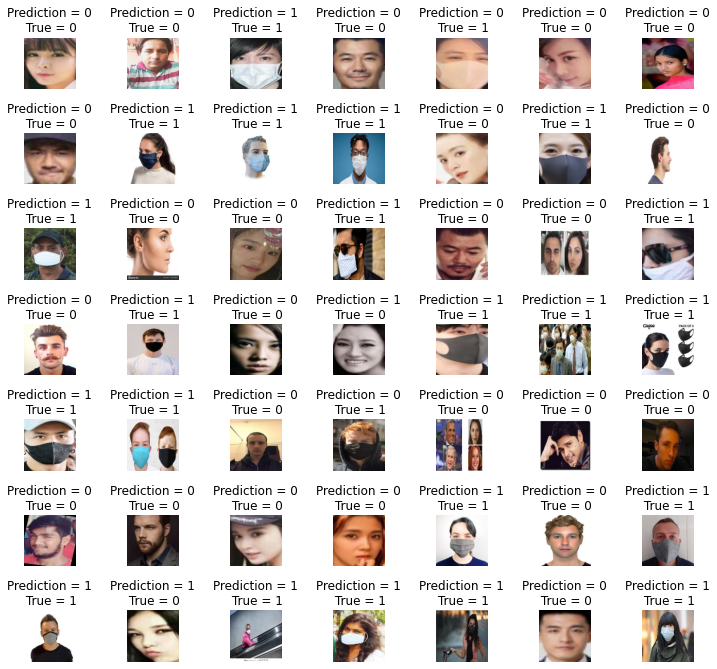

In [ ]:
L = 7
W = 7
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(X_test[i][:,:,::-1])
    axes[i].set_title('Prediction = {}\n True = {}'.format(predicted_classes[i], np.argmax(y_test[i], axis=None, out=None)))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1)

In [ ]:
modelo.layers

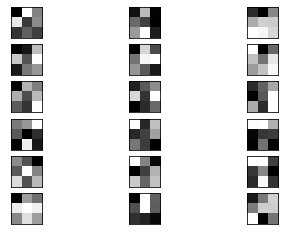

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = modelo.layers[0].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

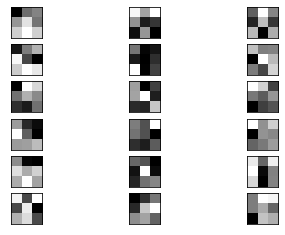

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = modelo.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

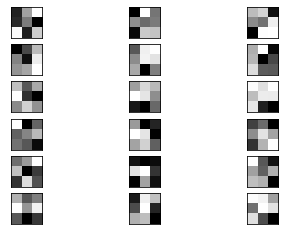

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = modelo.layers[4].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Angelina_Jolie_2_June_2014_%28cropped%29.jpg/330px-Angelina_Jolie_2_June_2014_%28cropped%29.jpg

--2022-04-26 06:36:13--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/Angelina_Jolie_2_June_2014_%28cropped%29.jpg/330px-Angelina_Jolie_2_June_2014_%28cropped%29.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25336 (25K) [image/jpeg]
Saving to: ‘330px-Angelina_Jolie_2_June_2014_(cropped).jpg’

330px-Angelina_Joli 100%[===================>]  24.74K  --.-KB/s    in 0.01s   

2022-04-26 06:36:13 (2.03 MB/s) - ‘330px-Angelina_Jolie_2_June_2014_(cropped).jpg’ saved [25336/25336]



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)        18496     
                                                             

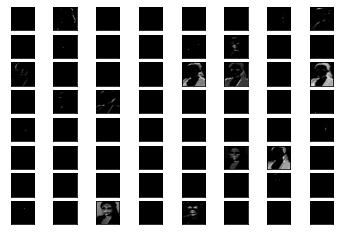

<Figure size 432x288 with 0 Axes>

In [ ]:

from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims
from keras.applications.vgg16 import preprocess_input

# redefine model to output right after the first hidden layer
model = Model(inputs=modelo.inputs, outputs=modelo.layers[4].output)
model.summary()
# load the image with the required shape
img = load_img('330px-Angelina_Jolie_2_June_2014_(cropped).jpg', target_size=(100, 100,3))
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot all 64 maps in an 8x8 squares
square = 8
print(feature_maps.shape)

ix = 1
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		ax = plt.subplot(square, square, ix,)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
		ix += 1
# show the figure
plt.show()
plt.subplots_adjust(wspace = 1)

(100, 100, 3)


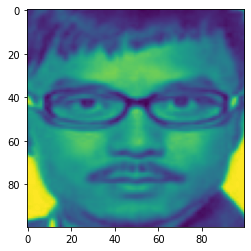

In [ ]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X_train[10].reshape(1,100,100,3))


print(X_train[10].shape)

plt.imshow(X_train[10][:,:,0]);


def display_activation(activations, col_size, row_size, act_index):
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1




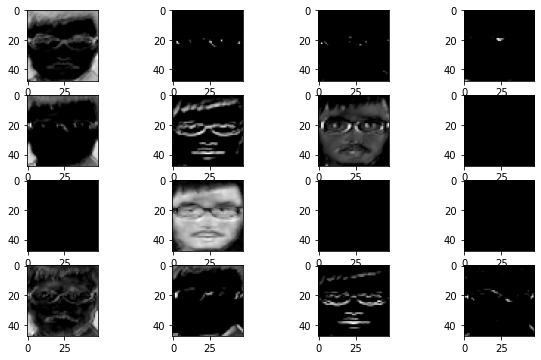

In [ ]:
#https://www.codeastar.com/visualize-convolutional-neural-network/
display_activation(activations, 4, 4, 3)

#Conclusiones
Con un 93% de datos correctos el modelo termina siendo muy exitoso, a tal punto que se podría aplicar en la vida real sin problema alguno.